In [7]:
# If you find this work useful please consider citing using the following .bib or text entry:

#Text entry
#Abichandani, Pramod and Lobo, Deepan and Ford, Gabriel and Bucci, Donald and Kam, Moshe. "Wind Measurement and Simulation Techniques in Multi-Rotor Small Unmanned Aerial Vehicles." IEEE Access 8 (2020): 54910-54927.

# Bib entry

# @article{abichandani2020wind,
#   title={Wind Measurement and Simulation Techniques in Multi-Rotor Small Unmanned Aerial Vehicles},
#   author={Abichandani, Pramod and Lobo, Deepan and Ford, Gabriel and Bucci, Donald and Kam, Moshe},
#   journal={IEEE Access},
#   volume={8},
#   pages={54910--54927},
#   year={2020},
#   publisher={IEEE}
# }

# Link to Original GitHub Repo: https://github.com/radlab-sketch/drydenModelPython

###########################################################################################################

import scipy.io as sio
import numpy as np
import math
import seaborn as sns
from scipy.signal import butter, lfilter, freqz, firwin
from scipy import signal
from matplotlib import pyplot as plt
import csv
from matplotlib.colors import Normalize

In [50]:
class Wind_Model():

    def __init__(self, turbulence = 10, max_time=5, samples_per_sec=200, seed=None):
        """Create the Wind Model.

        Args:
            veh_alt: The altitude of the UAV in meters 

            veh_speed: The Speed of the UAV in m/s

            turbulence: The turbulence parameter for the model in meters per second.

            max_time: The max time of the flight. The model will generate a constant wind model up to this time. 
                If a time is asked for beyond this time, a new model will be generated.
            
            samples_per_second: The number of samples per second in the Dryden Model.

        """
        self.wind_vec_list = {}
        self.turb = turbulence
        self.max_t = max_time
        self.samples_per_sec = samples_per_sec
        self.seed = seed

    #Low altitude Model

    #transfer function for along-wind
    def u_transfer_function(self, airspeed, height, turbulence):
        """Creates the transfer function for along-wind or wind in the x direction.

        This will use the inputted vehicle airspeed and height in the calculation.

        Args:
            airspeed: The airspeed of the UAV in m/s.

            height: The height of the UAV in meters.

            turbulence: Defined as the wind speed at 20 feet (6 meters).
                Determines how turbulent the wind is. 

        Returns:
            The corresponding transfer function.

        """

        # turbulence level defines value of wind speed in knots at 20 feet
        # turbulence_level = self.turb * 0.514444 # convert speed from knots to meters per second
        turbulence_level = turbulence

        length_u = height / ((0.177 + 0.000823*height)**(0.2))
        # length_u = 1750
        sigma_w = 0.1 * turbulence_level 
        sigma_u = sigma_w / ((0.177 + 0.000823*height) ** (0.4))
        num_u = [sigma_u * (math.sqrt((2 * length_u) / (math.pi * airspeed))) * airspeed]
        den_u = [length_u, airspeed]
        H_u = signal.TransferFunction(num_u, den_u)
        return H_u

    #transfer function for cross-wind
    def v_transfer_function(self, airspeed, height, turbulence):
        """Creates the transfer function for cross-wind or wind in the y direction.

        This will use the inputted vehicle airspeed and height in the calculation.

        Args:
            airspeed: The airspeed of the UAV in m/s.

            height: The height of the UAV in meters.

            turbulence: Defined as the wind speed at 20 feet (6 meters).
                Determines how turbulent the wind is. 
        
        Returns:
            The corresponding transfer function

        """
        #turbulence level defines value of wind speed in knots at 20 feet
        # turbulence_level = self.turb * 0.514444 # convert speed from knots to meters per second
        turbulence_level = turbulence

        length_v = height / ((0.177 + 0.000823*height)**(0.2))
        # length_v = 1750
        sigma_w = 0.1 * turbulence_level 
        sigma_v = sigma_w / ((0.177 + 0.000823*height) ** (0.4))
        b = sigma_v * (math.sqrt((length_v) / (math.pi * airspeed)))
        Lv_V = length_v / airspeed
        num_v = [(math.sqrt(3)*Lv_V*b), b]
        den_v = [(Lv_V**2), 2*Lv_V, 1]
        H_v = signal.TransferFunction(num_v, den_v)
        return H_v

    #transfer function for vertical-wind
    def w_transfer_function(self, airspeed, height, turbulence):
        """Creates the transfer function for vertical-wind or wind in the z direction.

        This will use the inputted vehicle airspeed and height in the calculation.

        Args:
            airspeed: The airspeed of the UAV in m/s.

            height: The height of the UAV in meters.

            turbulence: Defined as the wind speed at 20 feet (6 meters).
                Determines how turbulent the wind is. 
        
        Returns:
            The corresponding transfer function

        """

        #turbulence level defines value of wind speed in knots at 20 feet
        # turbulence_level = self.turb * 0.514444 # convert speed from knots to meters per second
        turbulence_level = turbulence

        length_w = height
        # length_w = 1750
        sigma_w = 0.1 * turbulence_level 
        c = sigma_w * (math.sqrt((length_w) / (math.pi * airspeed)))
        Lw_V = length_w / airspeed
        num_w = [(math.sqrt(3)*Lw_V*c), c]
        den_w = [(Lw_V**2), 2*Lw_V, 1]
        H_v = signal.TransferFunction(num_w, den_w)
        return H_v

    # t_w = []
    # noise1 = []
    # noise2 = []
    # noise3 = []
    # def read_csv_file():
    #     with open('white_noise.csv') as csv_file:
    #         csv_reader = csv.reader(csv_file, delimiter=',')
    #         for row in csv_reader:
    #                 t_w.append(float(row[0]))
    #                 noise1.append(float(row[1]))
    #                 noise2.append(float(row[2]))
    #                 noise3.append(float(row[3]))


    def dryden_wind_velocities(self, airspeed, height, turbulence = None, max_time = None, show_figs=False, save_figs=False):
        """Create a dryden wind model for a maximum time.

        Args:
            airspeed: The airspeed of the UAV in m/s.

            height: The height of the UAV in meters.

            turbulence: Defined as the wind speed at 20 feet (6 meters).
                Determines how turbulent the wind is. Default 

            seed: A random seed to start generating values for the model. If left blank, will be randomly determined

            show_figs: If True, the model graphs and figures will be shown

            save_figs: If True, the model graphs and figures will be saved to a file
        
        Returns:
            The time array, x-wind velocity array, y-wind velocity array, and the z-wind velocity array

        """

        if turbulence is None:
            turb_level = self.turb
        else:
            turb_level = turbulence
        
        # print(turb_level)

        if max_time is None:
            max_time = self.max_t

        # height and airspeed converted to feet and feet/sec
        height = float(height) * 3.28084
        airspeed = float(airspeed) * 3.28084
        # Generate white gaussian noise 
        mean = 0
        std = 1 
        # create a sequence of 1000 equally spaced numeric values from 0 - 5
        # Original Code:
        # t_p = np.linspace(0,5,1000)
        # num_samples = 1000
        t_p = np.linspace(0,max_time,(max_time * self.samples_per_sec))
        num_samples = max_time * self.samples_per_sec
        
        # seed = 23341 # default
        seed = self.seed

        if seed is None:
            seed = int(np.random.rand() * 10000)

        # the random number seed used same as from SIMULINK blockset
        np.random.seed(seed)
        samples1 = 10*np.random.normal(mean, std, size= num_samples)

        np.random.seed(None if seed is None else seed + 1)
        samples2 = 10*np.random.normal(mean, std, size= num_samples)

        np.random.seed(None if seed is None else seed + 2)
        samples3 = 10*np.random.normal(mean, std, size= num_samples)

        #generate tranfer function for dryden wind speeds in along wind direction, cross-wind, and vertical-wind directions
        tf_u = self.u_transfer_function(airspeed, height, turb_level)
        tf_v = self.v_transfer_function(airspeed, height, turb_level)
        tf_w = self.w_transfer_function(airspeed, height, turb_level)

        # Scale factor used to scale the white gaussian noise inputs. The scale factor used here is 10
        #scale_factor = 10

        # n1 = [i * scale_factor for i in noise1]
        # n2 = [i * scale_factor for i in noise2]
        # n3 = [i * scale_factor for i in noise3]

        # compute response to tranfer function
        tout1, y1, x1 = signal.lsim(tf_u, samples1, t_p)
        # tout1, y1, x1 = signal.lsim(tf_u, n1, t_w)
        # covert obtained values to meters/second
        y1_f = [i * 0.305 for i in y1]
        tout2, y2, x2 = signal.lsim(tf_v, samples2, t_p)
        # tout2, y2, x2 = signal.lsim(tf_v, n2, t_w)
        y2_f = [i * 0.305 for i in y2]
        tout3, y3, x3 = signal.lsim(tf_w, samples3, t_p)
        # tout3, y3, x3 = signal.lsim(tf_w, n3, t_w)
        y3_f = [i * 0.305 for i in y3]

        if not show_figs:
            return t_p, y1_f, y2_f, y3_f

        #plots for along-wind velocities generated using Python
        plt.figure(1)

        plt.plot(t_p, y1_f, 'b')
        # plt.plot(t_w, y1_f, 'b')
        plt.ylabel('along-wind in m/s (P)')
        plt.xlabel('time in seconds')
        plt.grid(True)

        if save_figs:
            plt.savefig('along-wind')


        #plots for cross-wind velocities generated using Python
        plt.figure(2)

        plt.plot(t_p, y2_f, 'r')
        # plt.plot(t_w, y2_f, 'r')
        plt.ylabel('cross-wind in m/s (P)')
        plt.xlabel('time in seconds')
        plt.grid(True)

        if save_figs:
            plt.savefig("cross wind")

        #plots for vertical-wind velocities generated using Python
        plt.figure(3)

        plt.plot(t_p, y3_f, 'g')
        # plt.plot(t_w, y3_f, 'g')
        plt.ylabel('vertical-wind in m/s (P)')
        plt.xlabel('time in seconds')
        plt.grid(True)

        if save_figs:
            plt.savefig("vertical wind")

        # Show all plots
        plt.show()

        return t_p, y1_f, y2_f, y3_f
    
    def get_model_index(self, time):
        """Get the index of the model we are looking for

        This is used mainly if the time > self.max_time, in which multiple wind models have been created

        Args:
            time: The time of sampling.
        
        Returns:
            The index of the model in self.wind_vec_list
        
        """
        return int(time) - (int(time) % self.max_t)

    def find_wind_vec(self, sample_time, _show=False, _save=False):
        """Get the wind model corresponding to the time

        Args:

            sample_time: The time in which the Dryden model was sampled

            _show: If a new model is created, this determines whether we should show the Dryden model figures. For testing.

            _save: If a new model is created, this determines whether we should save the Dryden model figures to a file. For Testing.
        
        """

        index = self.get_model_index(sample_time)

        if index not in self.wind_vec_list:
            self.wind_vec_list[index] = self.dryden_wind_velocities(show_figs=_show, save_figs=_save)

        return self.wind_vec_list[index]
        

    def get_wind_vector(self, sample_time : float, base_wind_vec: list, show=False, save=False):
        """Get the wind vector in the wind model corresponding to the current time, vehicle speed, and altitude.

        Args:
            sample_time: The current time to be sampled from the model

            base_wind_vec: The x, y, and z wind velocities to be added to the wind model.

            show: If a new model is created, this determines whether we should show the Dryden model figures. For testing.

            save: If a new model is created, this determines whether we should save the Dryden model figures to a file. For Testing.

        """

        time, x_wind, y_wind, z_wind = self.find_wind_vec(sample_time, _show=show, _save=save)
        
        index = int(sample_time * self.samples_per_sec) % (self.max_t * self.samples_per_sec)

        return (base_wind_vec[0] + x_wind[index], base_wind_vec[1] + y_wind[index], base_wind_vec[2] + z_wind[index])
    

    def get_wind_vector_waypoint(self, start_wp: list, end_wp: list, veh_speed: float, base_wind_vec: list, turbulence: int = None, show=False, save=False):
        """Get the wind vectors corresponding to a length of a trajectory.
        
        Args:
            start_wp: The starting waypoint for the trajectory in meters.

            end_wp: The ending waypoint for the trajectory in meters.

            base_wind_vec: The constant wind vector across the trajectory.

            show: If a new model is created, this determines whether we should show the Dryden model figures. For testing.

            save: If a new model is created, this determines whether we should save the Dryden model figures to a file. For Testing.

        Returns:
        
        """
        start_wp = np.array(start_wp)
        end_wp = np.array(end_wp)

        diff = end_wp - start_wp

        dist = np.linalg.norm(diff)

        total_time = dist / veh_speed

        avg_height = (start_wp[2] + end_wp[2])/2
        # print("height:",avg_height)

        time, x_wind, y_wind, z_wind = self.dryden_wind_velocities(veh_speed, avg_height, turbulence, max_time = math.ceil(total_time))

        time = np.array(time)
        x_wind = np.array(x_wind)
        y_wind = np.array(y_wind)
        z_wind = np.array(z_wind)

        x_wind = x_wind + base_wind_vec[0]
        y_wind = y_wind + base_wind_vec[1]
        z_wind = z_wind + base_wind_vec[2]

        wind_vecs = np.array([[_x, _y, _z] for _x, _y, _z in zip(x_wind, y_wind, z_wind)])

        single_segment = diff / (self.samples_per_sec * total_time)

        locations = []
        for i in range(math.ceil(self.samples_per_sec * total_time)):
            locations.append(single_segment * i + start_wp)
        
        locations = np.array(locations)
        size = locations.shape[0]
        return time[:size], locations, wind_vecs[:size]


In [51]:
def vec_to_mag(wind_vec: list):
    mags = [np.linalg.norm(x) for x in wind_vec]
    return mags

In [52]:
samp_per_sec = 200
wind_model = Wind_Model(turbulence=5, max_time=60, samples_per_sec=samp_per_sec)
base_wind = [2, 2, 0]
time_1, locs_1, wind_1 = wind_model.get_wind_vector_waypoint([1, 3, 6], [15, 1, 6], 6, turbulence=7.7, base_wind_vec=base_wind)
time_2, locs_2, wind_2 = wind_model.get_wind_vector_waypoint([15, 3, 6], [15, 15, 6], 6, turbulence=7.7, base_wind_vec=base_wind)
time_3, locs_3, wind_3 = wind_model.get_wind_vector_waypoint([15, 15, 6], [1, 15, 6.3], 6, turbulence=7.7, base_wind_vec=base_wind)
time_4, locs_4, wind_4 = wind_model.get_wind_vector_waypoint([1, 15, 6.3], [1, 3, 6], 6, turbulence=7.7, base_wind_vec=base_wind)

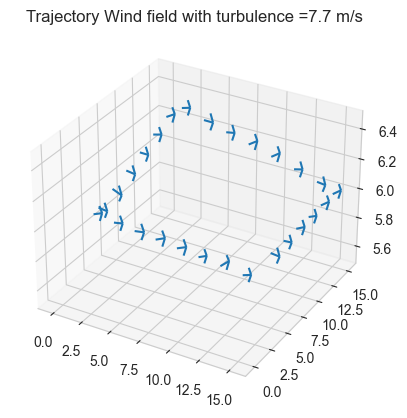

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-1, 16])
ax.set_ylim([-1, 16])
ax.set_zlim([5.5, 6.5])
skip = int(samp_per_sec/3)

x = np.concatenate((locs_1[:, 0], locs_2[:, 0], locs_3[:, 0], locs_4[:, 0]))[::skip]
y = np.concatenate((locs_1[:, 1], locs_2[:, 1], locs_3[:, 1], locs_4[:, 1]))[::skip]
z = np.concatenate((locs_1[:, 2], locs_2[:, 2], locs_3[:, 2], locs_4[:, 2]))[::skip]

u = np.concatenate((wind_1[:, 0], wind_2[:, 0], wind_3[:, 0], wind_4[:, 0]))[::skip]
v = np.concatenate((wind_1[:, 1], wind_2[:, 1], wind_3[:, 1], wind_4[:, 1]))[::skip]
w = np.concatenate((wind_1[:, 2], wind_2[:, 2], wind_3[:, 2], wind_4[:, 2]))[::skip]

ax.quiver(x, y, z, u, v, w, length=0.23)
plt.title("Trajectory Wind field with turbulence =7.7 m/s")
#plt.savefig("Wind_trajectory_7_7.png")
plt.show()

In [67]:
turb = 5

wind_model = Wind_Model(turbulence=turb, max_time=60, samples_per_sec=2000, seed=27214)
time, locs, wind_5 = wind_model.get_wind_vector_waypoint([1, 1, 6], [200, 3, 6], 6, turbulence=7.7, base_wind_vec=[5,0,0])
time, locs, wind_10 = wind_model.get_wind_vector_waypoint([1, 1, 6], [200, 3, 6], 6,  turbulence=15.4, base_wind_vec=[5,0,0])
time, locs, wind_15 = wind_model.get_wind_vector_waypoint([1, 1, 6], [200, 3, 6], 6, turbulence=23, base_wind_vec=[5,0,0])

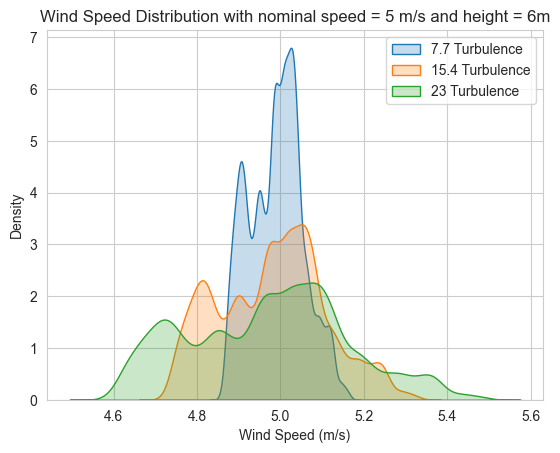

In [69]:
sns.set_style('whitegrid')
sns.kdeplot(np.linalg.norm(wind_5, axis=1), fill=True, label='7.7 Turbulence')
sns.kdeplot(np.linalg.norm(wind_10, axis=1), fill=True, label='15.4 Turbulence')
sns.kdeplot(np.linalg.norm(wind_15, axis=1), fill=True, label='23 Turbulence')
plt.legend()
plt.xlabel("Wind Speed (m/s)")
plt.title("Wind Speed Distribution with nominal speed = 5 m/s and height = 6m")
plt.savefig("turb_dist_seaborn_2.png")
plt.show()

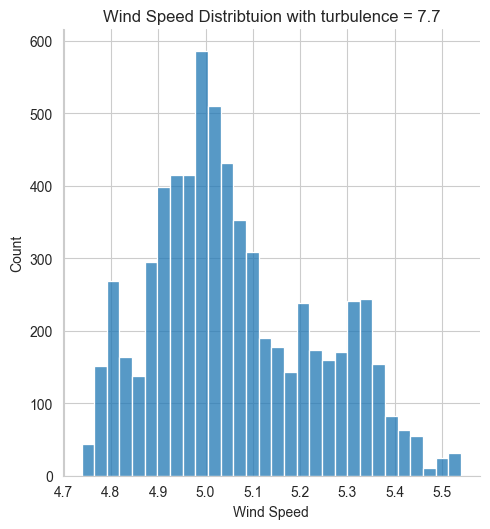

In [23]:
ax = sns.displot(np.linalg.norm(wind_5, axis=1))
ax.set(xlabel='Wind Speed',
       ylabel='Count',
       title='Wind Speed Distribtuion with turbulence = 7.7')


(6634,)


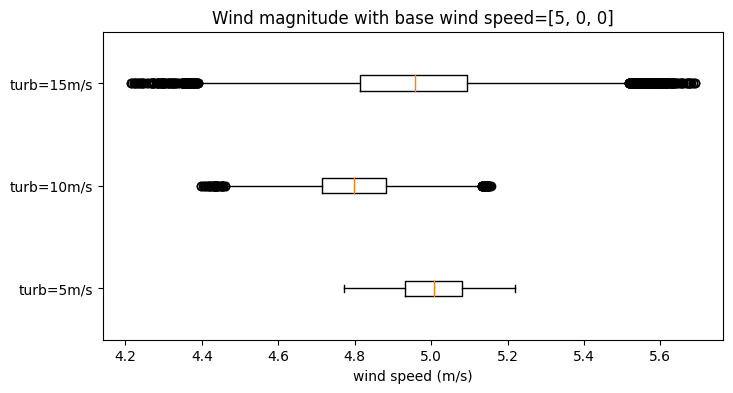

In [348]:
data = np.linalg.norm(wind_5, axis=1)
print(data.shape)

plt.figure(figsize=(8,4))

plt.boxplot(np.linalg.norm(wind_5, axis=1), positions=[1], vert=False, labels=['turb=5m/s'])
plt.boxplot(np.linalg.norm(wind_10, axis=1), positions=[2], vert=False, labels=['turb=10m/s'])
plt.boxplot(np.linalg.norm(wind_15, axis=1), positions=[3], vert=False, labels=['turb=15m/s'])
plt.xlabel("wind speed (m/s)")
plt.title("Wind magnitude with base wind speed=[5, 0, 0]")

plt.savefig("speed_dist.png")
plt.show()

In [351]:
turb = 5

wind_model = Wind_Model(turbulence=turb, max_time=60, samples_per_sec=200)
time, locs, wind = wind_model.get_wind_vector_waypoint([1, 1, 20], [100, 3, 20], 6, turbulence=turb, base_wind_vec=[0,0,0])

height: 20.0
5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


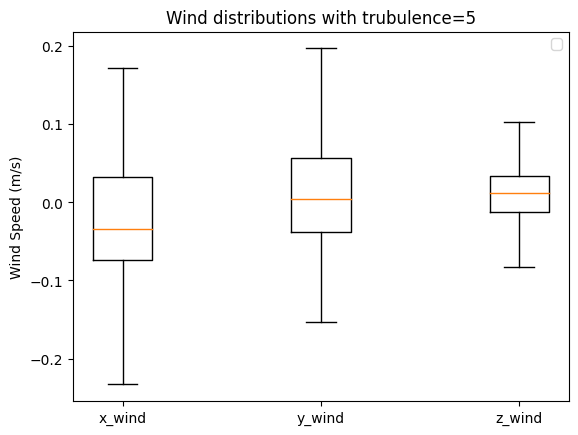

In [352]:

bpl1 = plt.boxplot(wind[:, 0], positions=[1], sym='', widths=0.6, labels=['x_wind'])
bpl2 = plt.boxplot(wind[:, 1], positions=[3], sym='', widths=0.6, labels=['y_wind'])
bpl3 = plt.boxplot(wind[:, 2], positions=[5], sym='', widths=0.6, labels=['z_wind'])

plt.title("Wind distributions with trubulence=" + str(turb))

plt.legend()
plt.savefig("dir_dist_turb_" + str(turb) + ".png")
plt.ylabel("Wind Speed (m/s)")
plt.show()

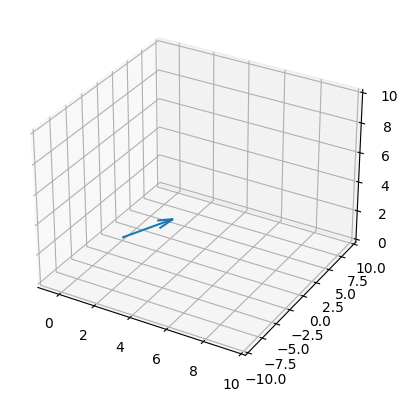

In [160]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.set_xlim([-1, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([0, 10])

ax.quiver(0, 0, 0, 2, 3, 1)


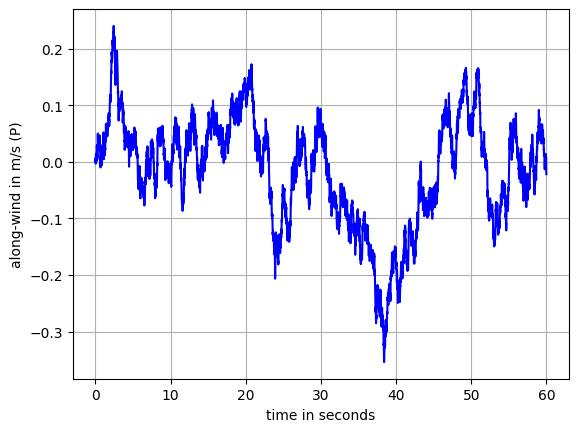

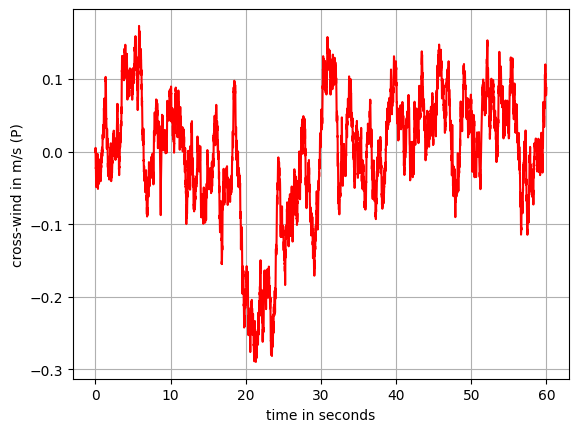

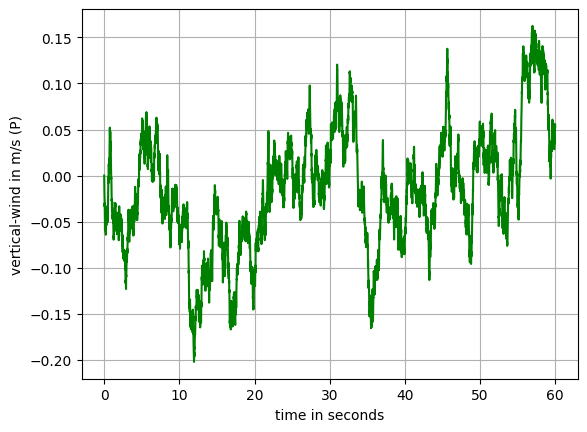

(4.991645399198936, -0.05131070811673171, -0.11509342486676673)
(5.000297767830101, -0.0803083451951224, -0.11463267135159347)
(5.017529541833184, -0.05845710811044038, -0.08916709510618659)
(4.9672172889985715, -0.06180335183887865, -0.09098239214564872)


In [11]:

# 									    get_wind_vector(sample_time, base_wind_vec)
wind_vec_1 = wind_model.get_wind_vector(14, 			   (5, 0, 0), show=True)

print(wind_vec_1)
print(wind_model.get_wind_vector(14.1, (5, 0, 0)))
print(wind_model.get_wind_vector(14.2, (5, 0, 0)))
print(wind_model.get_wind_vector(14.3, (5, 0, 0)))